In [ ]:
import json
import os
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
import ast
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Attention, Multiply, Lambda, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Colab Notebooks/2550Final")
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/2550Final


In [ ]:
def read_json_file(filepath):
  """Reads a JSON file and returns its contents as a Python dictionary.

  Args:
    filepath: The path to the JSON file.

  Returns:
    A Python dictionary representing the JSON data, or None if an error occurs.
  """
  try:
    with open(filepath, 'r') as f:
      data = json.load(f)
      return data
  except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    return None
  except json.JSONDecodeError:
    print(f"Error: Invalid JSON format in {filepath}")
    return None

filepath = 'JSON/combined_data.json'  # Replace with the actual path to your JSON file
data = read_json_file(filepath)


In [ ]:
if data:
  try:
    interpolated_df = pd.DataFrame(data['interpolated_data'])
    mask_df = pd.DataFrame(data['mask_data'])
    mergedType_df = pd.DataFrame(data['mergedType'])

    # Rename columns
    mask_df = mask_df.rename(columns={'g': 'g_mask', 'r': 'r_mask'})

    print("interpolated_data DataFrame:")
    print(interpolated_df.head())

    print("\nmask_data DataFrame:")
    print(mask_df.head())

    print("\nmergedType DataFrame:")
    print(mergedType_df.head())

  except KeyError as e:
    print(f"Error: Key not found in the JSON data: {e}")
  except Exception as e:
    print(f"An unexpected error occurred: {e}")


interpolated_data DataFrame:
                                                   g  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1207.785021350242, 1...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   r  
0  [0.0, 4822.216874913121, 4788.231540098279, 47...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [1894.0734307672656, 2173.4523233355967, 2503....  
4  [4474.146195208889, 4502.539762873916, 4530.34...  

mask_data DataFrame:
                                              g_mask  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...   
3  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4 

In [ ]:
if len(interpolated_df) == len(mask_df) == len(mergedType_df):
    # Concatenate the DataFrames horizontally
    combined_df = pd.concat([interpolated_df, mask_df, mergedType_df], axis=1)

    # Rename the column
    combined_df = combined_df.rename(columns={0: 'label'})

    print("\nCombined DataFrame:")
    print(combined_df.head())
else:
    print("Error: DataFrames do not have the same number of rows. Cannot combine.")



Combined DataFrame:
                                                   g  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1207.785021350242, 1...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   r  \
0  [0.0, 4822.216874913121, 4788.231540098279, 47...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [1894.0734307672656, 2173.4523233355967, 2503....   
4  [4474.146195208889, 4502.539762873916, 4530.34...   

                                              g_mask  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...   
3  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [0, 0, 0, 0, 0, 0, 0, 

# 四分

In [ ]:
# === 1. 数据载入与预处理 ===
df = combined_df.copy()

def safe_parse_array(x):
    if isinstance(x, str):
        return np.array(eval(x), dtype=np.float32)
    elif isinstance(x, (list, np.ndarray)):
        return np.array(x, dtype=np.float32)
    else:
        raise ValueError("Unknown type for array parsing.")

for col in ['g', 'r', 'g_mask', 'r_mask']:
    df[col] = df[col].apply(safe_parse_array)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# === 2. 分割数据集 ===
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

def prepare(df):
    g = np.stack(df['g'].values)
    r = np.stack(df['r'].values)
    g_mask = np.stack(df['g_mask'].values)
    r_mask = np.stack(df['r_mask'].values)
    X = np.stack([g, r], axis=-1)
    mask = np.stack([g_mask, r_mask], axis=-1)
    y = to_categorical(df['label'].values)
    labels = df['label'].values
    return X, mask, y, labels

X_train, mask_train, y_train, labels_train = prepare(train_df)
X_val, mask_val, y_val, labels_val = prepare(val_df)
X_test, mask_test, y_test, labels_test = prepare(test_df)

# === 3. 类别权重（变为每样本对应） ===
# 原始类别权重
cw = class_weight.compute_class_weight(class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label'])

# Clip
cw = np.clip(cw, 0.7, 8.0)

class_weight_dict = dict(enumerate(cw))

# 每个样本的 class_weight
class_weight_array = np.array([class_weight_dict[l] for l in labels_train])

# 每个样本是否有有效插值（mask为1）
mask_valid = np.any(mask_train == 1, axis=(1, 2)).astype(np.float32)

# 合并后的 sample_weight
sample_weight_total = class_weight_array * mask_valid

# === 4. 构建 CNN 模型 ===
def build_model_with_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # [batch, 100, 2]

    # 卷积
    x = Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)  # [batch, 50, 64]
    x = Conv1D(128, 5, activation='relu', padding='same')(x)  # [batch, 50, 128]

    # Self-Attention
    attention_out = Attention()([x, x])  # query=x, key=x → [batch, 50, 128]
    x = Multiply()([x, attention_out])   # 加权融合原始和注意力信息
    x = LayerNormalization()(x)

    # 输出
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_model_with_attention((100, 2), y_train.shape[1])
model.compile(optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])

model.summary()

# === 5. 训练模型 ===
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,            # 如果 5 个 epoch 没提升，就停止
    restore_best_weights=True  # 返回最优模型权重
)

history = model.fit(
    X_train, y_train,
    sample_weight=sample_weight_total,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping]
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │        704 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 128)   │     41,088 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 50, 128)   │          0 │ conv1d_1[0][0],   │
│ (Attention)         │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50, 128)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 128)   │        256 │ multiply[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,076 (230.77 KB)

 Trainable params: 59,076 (230.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.6388 - loss: 1.4049 - val_accuracy: 0.7516 - val_loss: 0.7924
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7412 - loss: 1.1071 - val_accuracy: 0.7186 - val_loss: 0.7823
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7522 - loss: 1.0361 - val_accuracy: 0.7315 - val_loss: 0.7022
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7503 - loss: 1.0422 - val_accuracy: 0.7307 - val_loss: 0.7391
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7473 - loss: 0.9812 - val_accuracy: 0.7428 - val_loss: 0.6896
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7598 - loss: 0.9309 - val_accuracy: 0.6994 - val_loss: 0.7907
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7432 - loss: 0.9355 - val_accuracy: 0.7412 - val_loss: 0.7082
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7554 - loss: 0.9827 - val_accuracy: 0

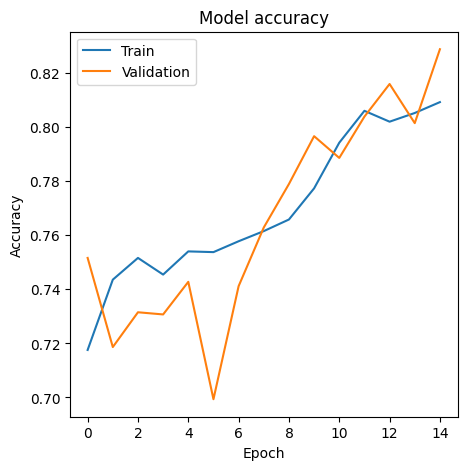

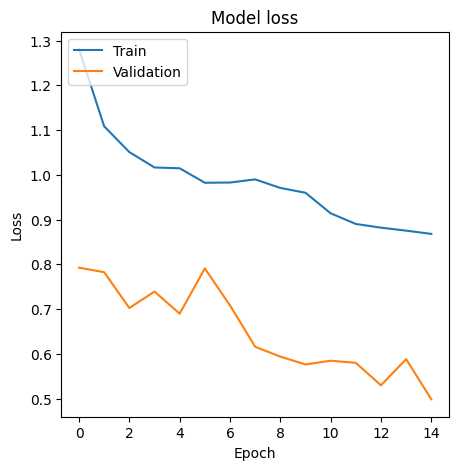

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'][:-5])
plt.plot(history.history['val_accuracy'][:-5])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'][:-5])
plt.plot(history.history['val_loss'][:-5])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


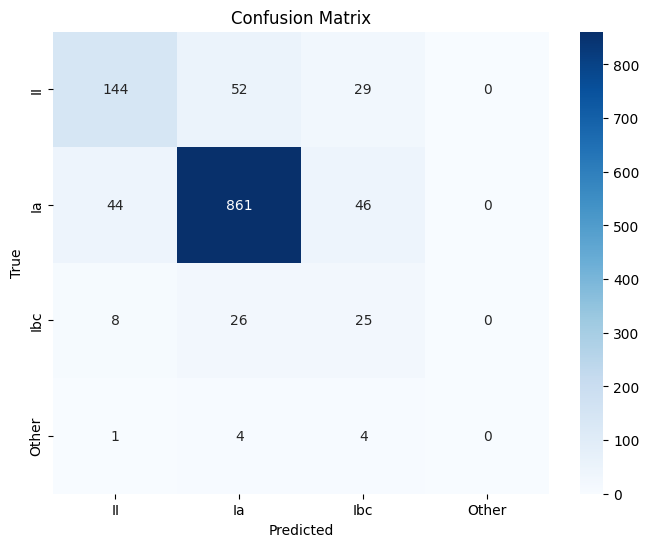

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Create a dictionary to store the results
results = {
    "all-labels": y_true.tolist(),  # Convert NumPy arrays to lists for JSON serialization
    "all-preds": y_pred_classes.tolist(),
    "all-probs": y_pred.tolist()
}

filepath = "JSON/four-class_cnn.json"

with open(filepath, "w") as json_file:
    json.dump(results, json_file, indent=4)  # Use indent for pretty printing

print(f"Model results saved to {filepath}")


Model results saved to JSON/four-class_cnn.json


# 二分

In [ ]:
combined_df_bin = combined_df.copy()
combined_df_bin['label'] = combined_df_bin['label'].replace(['Ia', 'II', 'IIn', 'Ib', 'Ibc'], ['Ia', 'Other', 'Other', 'Other', 'Other'])
combined_df_bin.head()

,g,r,g_mask,r_mask,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4822.216874913121, 4788.231540098279, 47...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Ia
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",Ia
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",Other
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 1207.785021350242, 1...","[1894.0734307672656, 2173.4523233355967, 2503....","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Ia
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4474.146195208889, 4502.539762873916, 4530.34...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Other


In [ ]:
# === 1. 读取数据 ===
df_bin = combined_df_bin.copy()

def safe_array(x):
    if isinstance(x, str):
        return np.array(eval(x), dtype=np.float32)
    elif isinstance(x, (list, np.ndarray)):
        return np.array(x, dtype=np.float32)
    else:
        raise ValueError("Invalid array format.")

for col in ['g', 'r', 'g_mask', 'r_mask']:
    df_bin[col] = df_bin[col].apply(safe_array)

df_bin['label'] = (df_bin['label'] == 'Ia').astype(int)

# === 2. 划分数据集 ===
train_bin, temp_bin = train_test_split(df_bin, test_size=0.4, stratify=df_bin['label'], random_state=42)
val_bin, test_bin = train_test_split(temp_bin, test_size=0.5, stratify=temp_bin['label'], random_state=42)

def prepare_bin(df):
    g = np.stack(df['g'].values)
    r = np.stack(df['r'].values)
    g_mask = np.stack(df['g_mask'].values)
    r_mask = np.stack(df['r_mask'].values)
    X = np.stack([g, r], axis=-1)
    mask = np.stack([g_mask, r_mask], axis=-1)
    y = to_categorical(df['label'].values)
    label_raw = df['label'].values
    return X, mask, y, label_raw

Xb_train, Mb_train, Yb_train, Lb_train = prepare_bin(train_bin)
Xb_val, Mb_val, Yb_val, Lb_val = prepare_bin(val_bin)
Xb_test, Mb_test, Yb_test, Lb_test = prepare_bin(test_bin)

# === 3. 类别权重 + mask 合并为 sample_weight ===
cw_bin = class_weight.compute_class_weight(class_weight='balanced',
                                           classes=np.unique(df_bin['label']),
                                           y=df_bin['label'])
cw_bin = np.clip(cw_bin, 0.7, 5.0)
cw_dict_bin = dict(enumerate(cw_bin))

class_weight_array_bin = np.array([cw_dict_bin[l] for l in Lb_train])
mask_valid_bin = np.any(Mb_train == 1, axis=(1, 2)).astype(np.float32)
sample_weight_bin = class_weight_array_bin * mask_valid_bin

# === 4. 模型结构：1D CNN + Attention ===
def build_attention_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    attn = Attention()([x, x])
    x = Multiply()([x, attn])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model_bin = build_attention_cnn((100, 2), Yb_train.shape[1])
model_bin.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# === 5. EarlyStopping ===
early_stop_bin = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === 6. 训练 ===
history_bin = model_bin.fit(Xb_train, Yb_train,
                            sample_weight=sample_weight_bin,
                            validation_data=(Xb_val, Yb_val),
                            epochs=100,
                            batch_size=256,
                            callbacks=[early_stop_bin])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.6058 - loss: 0.7796 - val_accuracy: 0.7018 - val_loss: 0.5942
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - accuracy: 0.6880 - loss: 0.6000 - val_accuracy: 0.7733 - val_loss: 0.5126
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.7566 - loss: 0.5671 - val_accuracy: 0.7323 - val_loss: 0.5600
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.7463 - loss: 0.5362 - val_accuracy: 0.7371 - val_loss: 0.5394
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.7702 - loss: 0.5115 - val_accuracy: 0.7106 - val_loss: 0.5344
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.7758 - loss: 0.4982 - val_accuracy: 0.8031 - val_loss: 0.4443
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.7935 - loss: 0.4818 - val_accuracy: 0.8240 - val_loss: 0.3867
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.8030 - loss: 0.4756 - val_accu

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


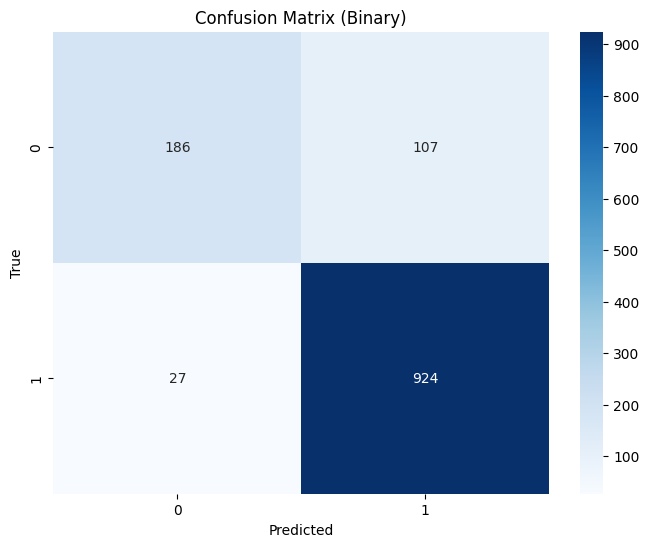

In [ ]:
y_pred_bin = model_bin.predict(Xb_test)
y_pred_classes_bin = np.argmax(y_pred_bin, axis = 1)
y_true_bin = np.argmax(Yb_test, axis = 1)

cm_bin = confusion_matrix(y_true_bin, y_pred_classes_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Binary)')
plt.show()


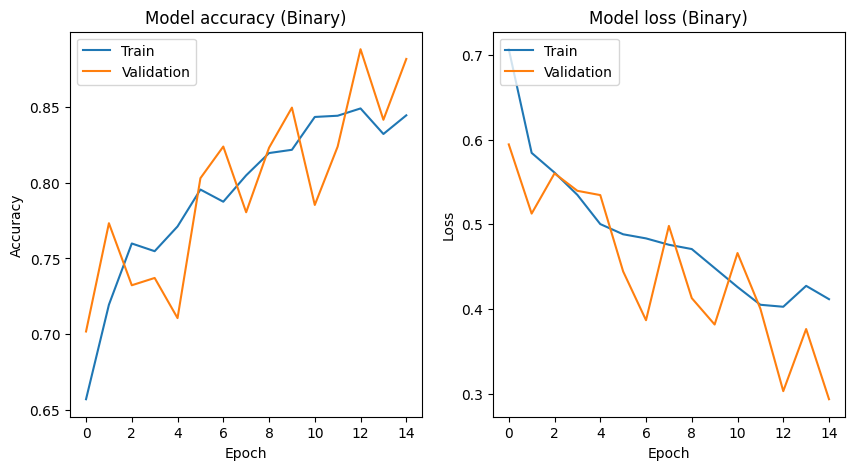

In [ ]:
#Plot training & validation accuracy values for binary
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bin.history['accuracy'][:-5])
plt.plot(history_bin.history['val_accuracy'][:-5])
plt.title('Model accuracy (Binary)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for binary
plt.subplot(1, 2, 2)
plt.plot(history_bin.history['loss'][:-5])
plt.plot(history_bin.history['val_loss'][:-5])
plt.title('Model loss (Binary)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Create a dictionary to store the results
results_bin = {
    "all-labels": y_true_bin.tolist(),
    "all-preds": y_pred_classes_bin.tolist(),
    "all-probs": y_pred_bin.tolist()
}

# Specify the file path for saving the JSON data
filepath_bin = "JSON/two-class_cnn.json"

# Save the results to a JSON file
with open(filepath_bin, "w") as json_file:
    json.dump(results_bin, json_file, indent=4)

print(f"Model results saved to {filepath_bin}")


Model results saved to JSON/two-class_cnn.json


# ROC曲线（四分）

In [ ]:
json_files = ['JSON/four-class_transformer.json', 'JSON/four-class_lstm.json', 'JSON/four-class_wavelet+PCA+mlp.json', 'JSON/four-class_gru.json', 'JSON/four-class_cnn.json']
transformer_data = read_json_file(json_files[0])
lstm_data = read_json_file(json_files[1])
wavelet_data = read_json_file(json_files[2])
gru_data = read_json_file(json_files[3])
cnn_data = read_json_file(json_files[4])

transformer_df = pd.DataFrame([transformer_data])
lstm_df = pd.DataFrame([lstm_data])
wavelet_df = pd.DataFrame([wavelet_data])
gru_df = pd.DataFrame([gru_data])
cnn_df = pd.DataFrame([cnn_data])

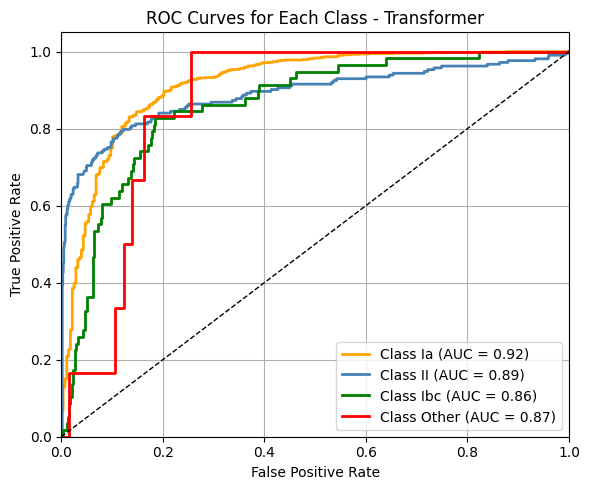

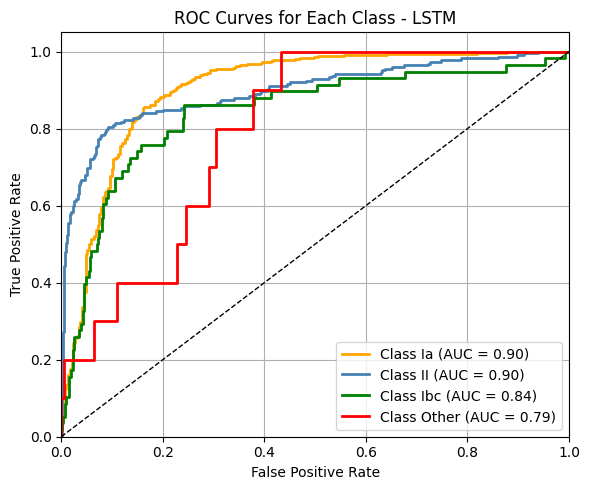

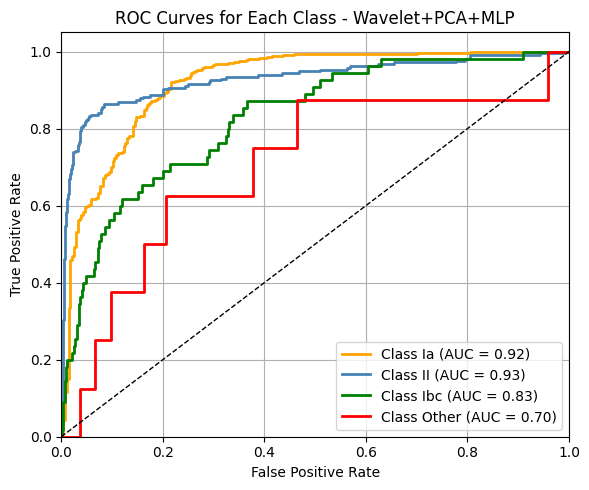

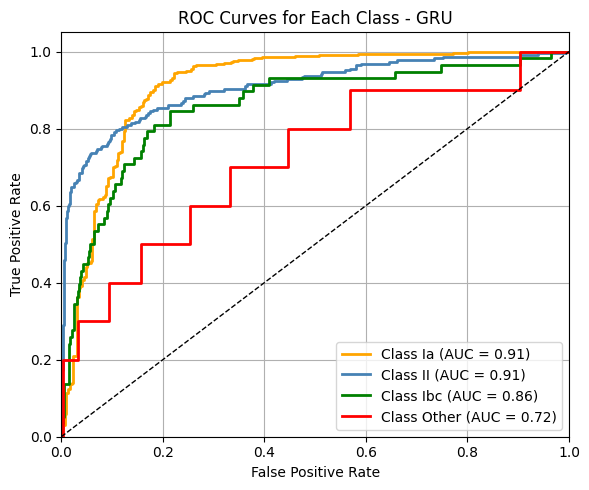

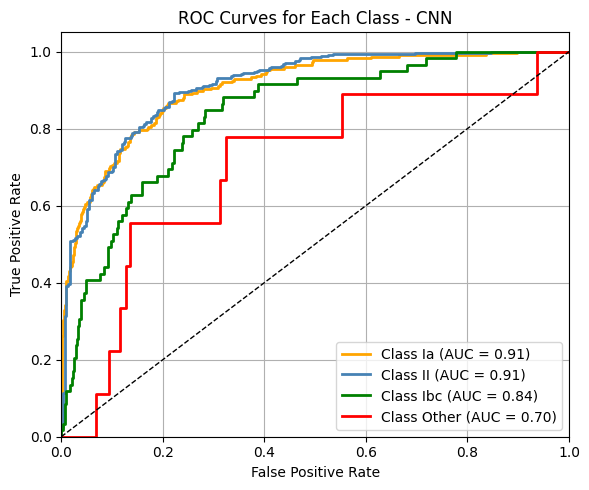

In [ ]:
# 模型路径和名称
json_files_4 = [
    'transformer_df',
    'lstm_df',
    'wavelet_df',
    'gru_df',
    'cnn_df'
]
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']

# 标签映射和颜色设定
class_names = ['Ia', 'II', 'Ibc', 'Other']  # index: 0=Ia, 1=II, 2=Ibc, 3=Other
colors = ['orange', 'steelblue', 'green', 'red']

# 遍历每个模型绘图
for data_4, model_name in zip([transformer_df, lstm_df, wavelet_df, gru_df, cnn_df], model_names):

    y_true = np.array(data_4['all-labels'].iloc[0]) # Access the first row since DataFrame contains one row
    y_score = np.array(data_4['all-probs'].iloc[0]) # Access the first row since DataFrame contains one row

    # 标签 one-hot
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
    n_classes = y_true_bin.shape[1]

    # 计算 ROC 曲线和 AUC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 绘图
    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i], color=colors[i],
            label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})',
            linewidth=2
        )

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Each Class - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

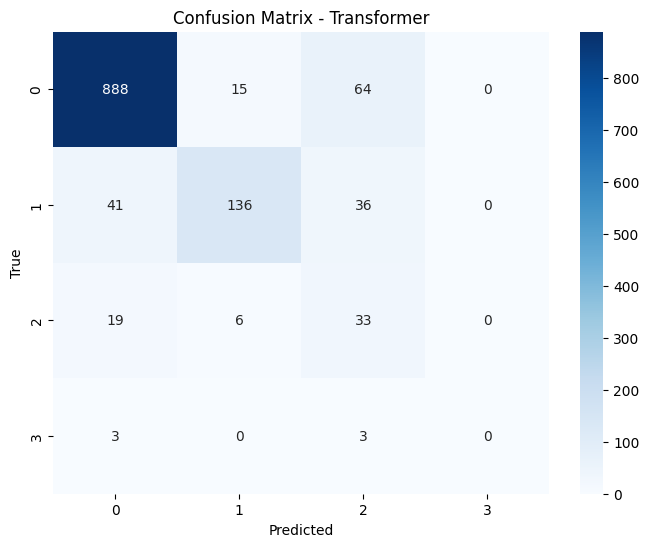

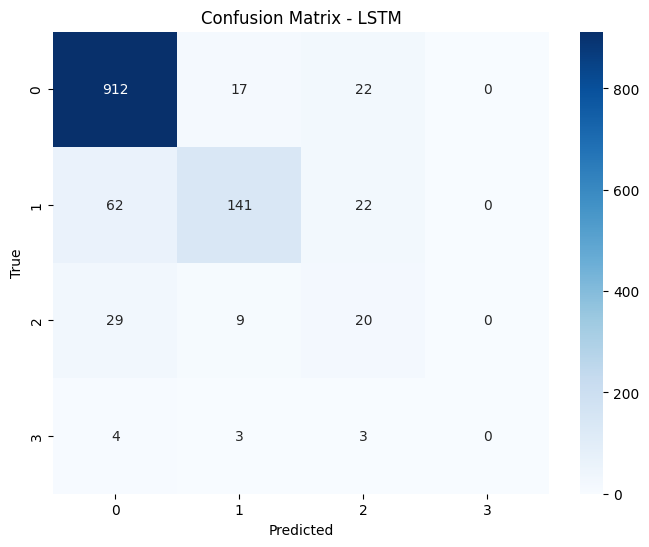

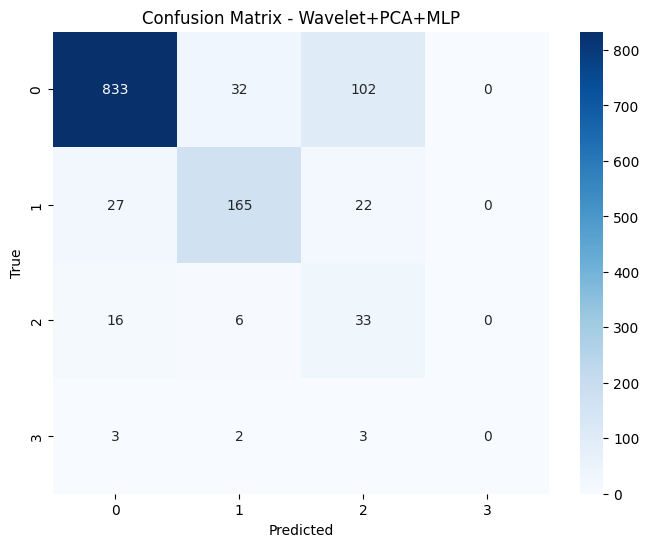

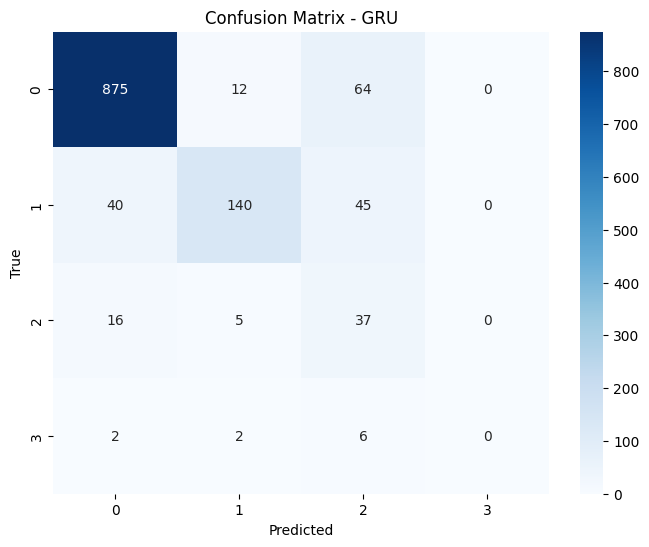

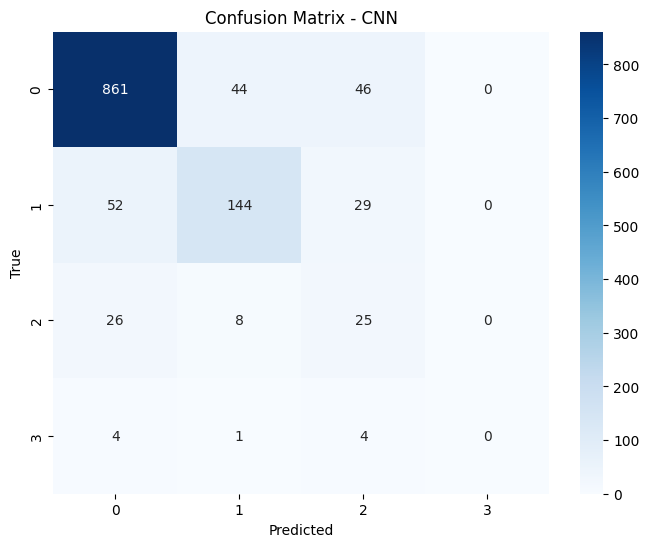

In [ ]:
# Iterate through each model to plot confusion matrices
for data_cm_4, model_name in zip([transformer_df, lstm_df, wavelet_df, gru_df, cnn_df], model_names):

    y_true = np.array(data_cm_4['all-labels'].iloc[0]) # Access the first element since it's a list within a list
    y_pred = np.array(data_cm_4['all-preds'].iloc[0])  # Access the first element since it's a list within a list

    # Swap labels for CNN model
    if model_name == 'CNN':
        y_true = np.where(y_true == 0, 1, np.where(y_true == 1, 0, y_true))
        y_pred = np.where(y_pred == 0, 1, np.where(y_pred == 1, 0, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


# ROC曲线（二分）

In [ ]:
json_files_bin = ['JSON/two-class_transformer.json', 'JSON/two-class_lstm.json', 'JSON/two-class_wavelet+PCA+mlp.json', 'JSON/two-class_gru.json', 'JSON/two-class_cnn.json']
transformer_data_bin = read_json_file(json_files_bin[0])
lstm_data_bin = read_json_file(json_files_bin[1])
wavelet_data_bin = read_json_file(json_files_bin[2])
gru_data_bin = read_json_file(json_files_bin[3])
cnn_data_bin = read_json_file(json_files_bin[4])

transformer_df_bin = pd.DataFrame([transformer_data_bin])
lstm_df_bin = pd.DataFrame([lstm_data_bin])
wavelet_df_bin = pd.DataFrame([wavelet_data_bin])
gru_df_bin = pd.DataFrame([gru_data_bin])
cnn_df_bin = pd.DataFrame([cnn_data_bin])

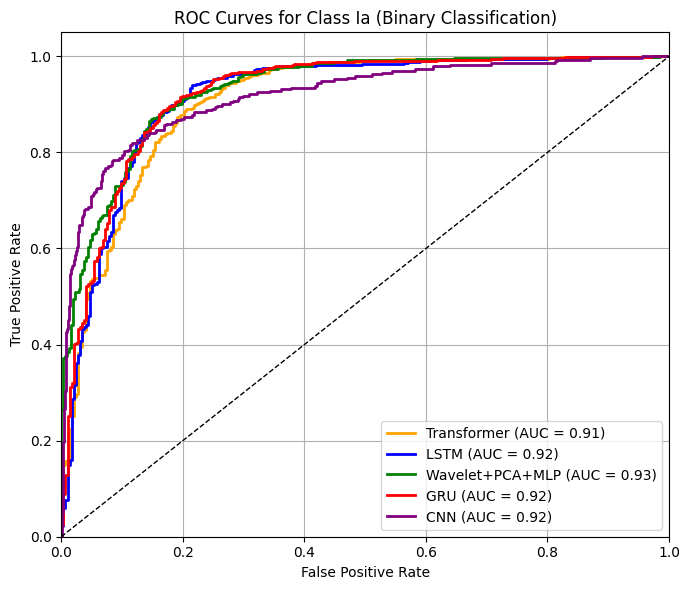

In [ ]:
# 模型路径和名称
json_files_bin = [
    'transformer_df_bin',
    'lstm_df_bin',
    'wavelet_df_bin',
    'gru_df_bin',
    'cnn_df_bin'
]
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']

# 类别名称（正类 = Ia）和颜色列表
class_name_2 = 'Ia'
colors_2 = ['orange', 'blue', 'green', 'red', 'purple']

# 创建一张图
plt.figure(figsize=(7, 6))

# 循环画每个模型的 ROC 曲线
for data_2, model_name, color_2 in zip([transformer_df_bin, lstm_df_bin, wavelet_df_bin, gru_df_bin, cnn_df_bin], model_names, colors_2):

    y_true_2 = np.array(data_2['all-labels'].iloc[0]) # Access the first row since DataFrame contains one row
    y_score_2 = np.array(data_2['all-probs'].iloc[0]) # Access the first row since DataFrame contains one row

    y_score_2 = y_score_2[:, 0]

    # 计算 ROC 曲线和 AUC，Ia 为正类
    fpr_2, tpr_2, _ = roc_curve(y_true_2, y_score_2, pos_label=0)
    roc_auc_2 = auc(fpr_2, tpr_2)

    # 画曲线
    plt.plot(
        fpr_2, tpr_2, color=color_2,
        label=f'{model_name} (AUC = {roc_auc_2:.2f})',
        linewidth=2
    )

# 添加随机参考线、图例和标题
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Class Ia (Binary Classification)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

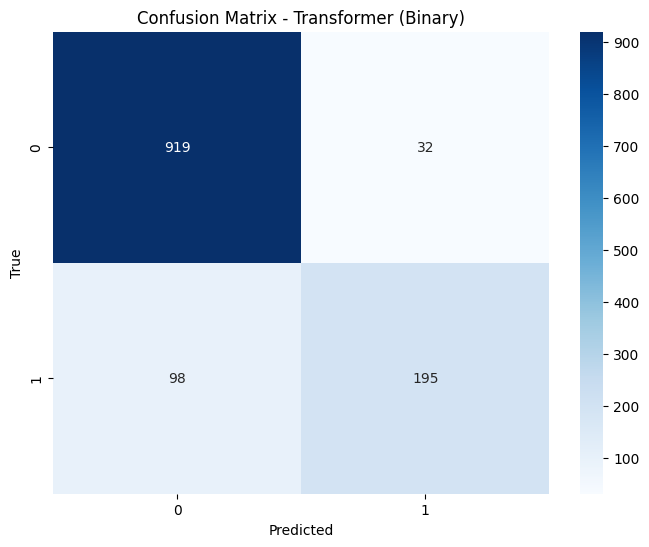

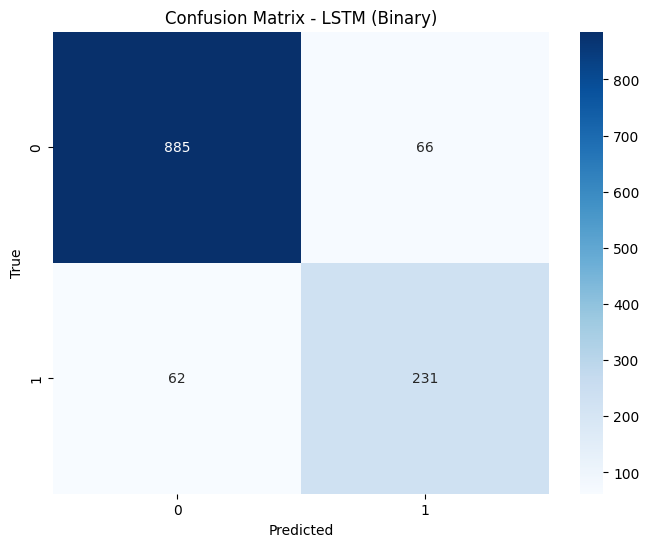

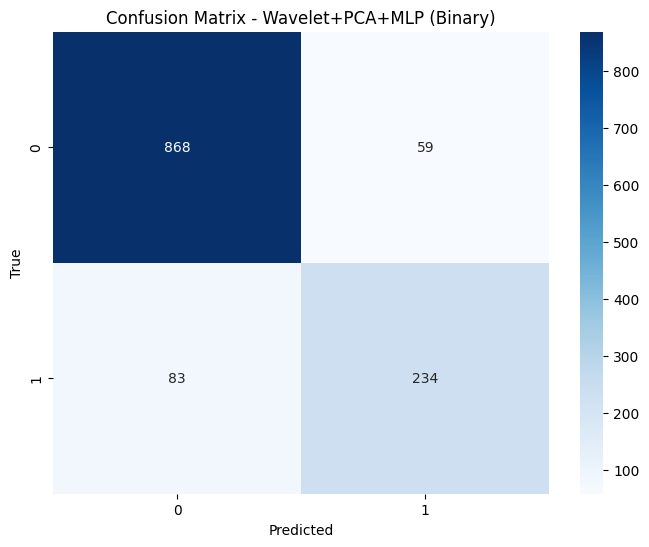

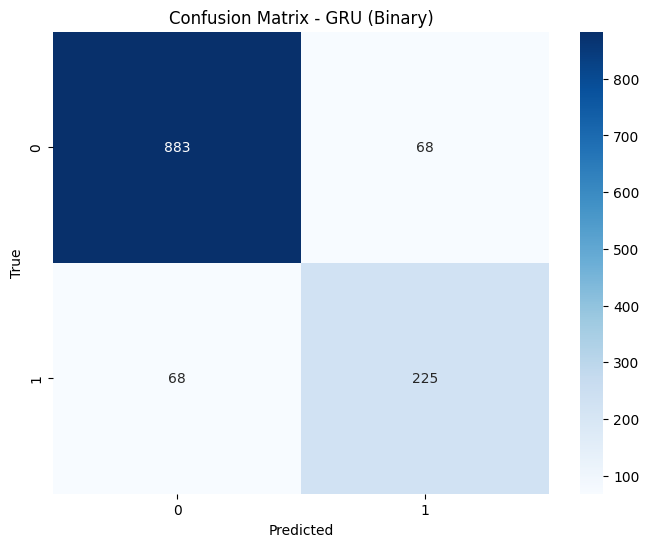

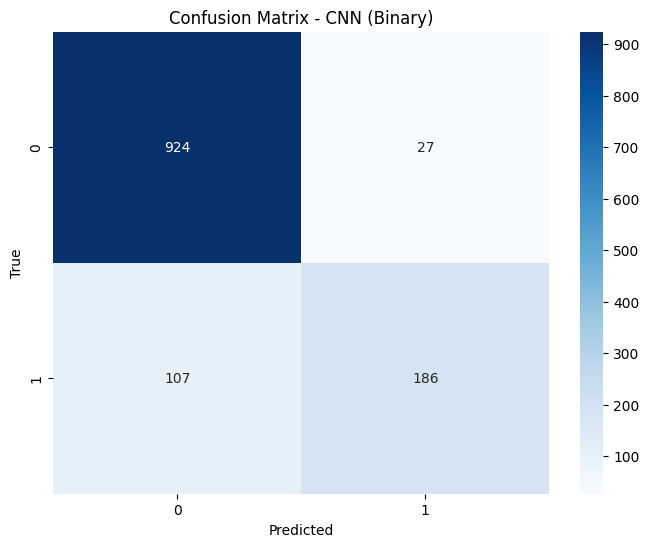

In [ ]:
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']

# Iterate through each model to plot confusion matrices
for data_2, model_name in zip([transformer_df_bin, lstm_df_bin, wavelet_df_bin, gru_df_bin, cnn_df_bin], model_names):
    # Access the first element of the 'all-labels' and 'all-preds' columns, which are lists
    y_true_2 = np.array(data_2['all-labels'].iloc[0])
    y_pred_2 = np.array(data_2['all-preds'].iloc[0])

    # Swap labels for CNN model if needed
    if model_name == 'CNN':
        y_true_2 = np.where(y_true_2 == 0, 1, np.where(y_true_2 == 1, 0, y_true_2))
        y_pred_2 = np.where(y_pred_2 == 0, 1, np.where(y_pred_2 == 1, 0, y_pred_2))

    cm = confusion_matrix(y_true_2, y_pred_2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name} (Binary)')
    plt.show()


# 最终结果

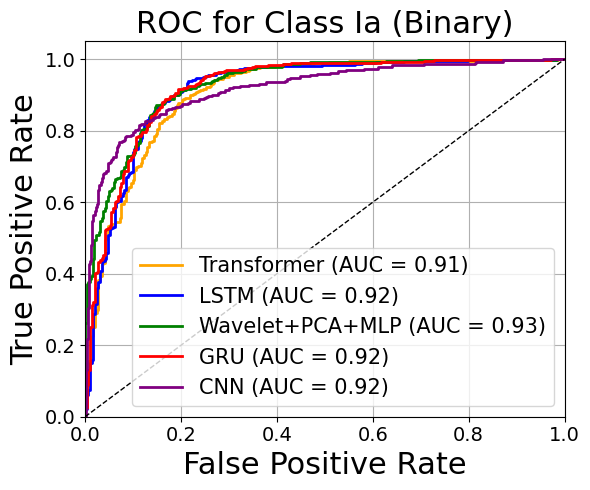

In [ ]:
# 类别名称
class_name_2 = 'Ia'
colors_2 = ['orange', 'blue', 'green', 'red', 'purple']

plt.figure(figsize=(6, 5))  # Increased figure size

for data_2, model_name, color_2 in zip([transformer_df_bin, lstm_df_bin, wavelet_df_bin, gru_df_bin, cnn_df_bin], model_names, colors_2):
    y_true_2 = np.array(data_2['all-labels'].iloc[0])
    y_score_2 = np.array(data_2['all-probs'].iloc[0])
    y_score_2 = y_score_2[:, 0]

    fpr_2, tpr_2, _ = roc_curve(y_true_2, y_score_2, pos_label=0)
    roc_auc_2 = auc(fpr_2, tpr_2)

    plt.plot(fpr_2, tpr_2, color=color_2, label=f'{model_name} (AUC = {roc_auc_2:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for Class Ia (Binary)', fontsize=22)
plt.legend(loc='lower right', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import f1_score

model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']
binary_data = [transformer_df_bin, lstm_df_bin, wavelet_df_bin, gru_df_bin, cnn_df_bin]


for model_name, data in zip(model_names, binary_data):
    y_true_bin = np.array(data['all-labels'].iloc[0])
    y_pred_classes_bin = np.array(data['all-preds'].iloc[0])

    if model_name == 'CNN':
      y_true_bin = np.where(y_true_bin == 0, 1, np.where(y_true_bin == 1, 0, y_true_bin))
      y_pred_classes_bin = np.where(y_pred_classes_bin == 0, 1, np.where(y_pred_classes_bin == 1, 0, y_pred_classes_bin))

    f1 = f1_score(y_true_bin, y_pred_classes_bin)
    print(f"F1 score for {model_name}: {f1}")


F1 score for Transformer: 0.75
F1 score for LSTM: 0.7830508474576271
F1 score for Wavelet+PCA+MLP: 0.7672131147540984
F1 score for GRU: 0.7679180887372014
F1 score for CNN: 0.7351778656126482


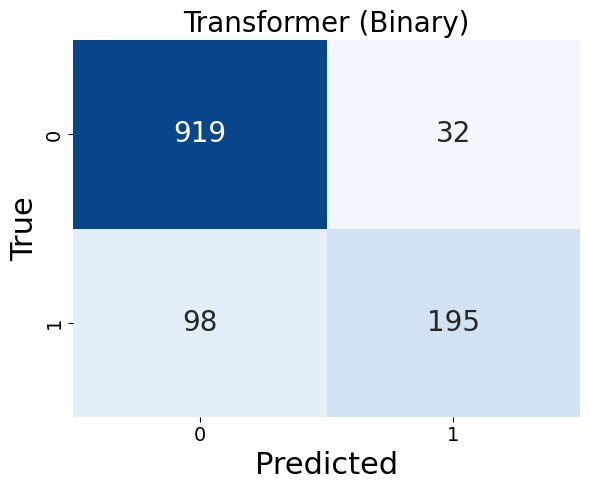

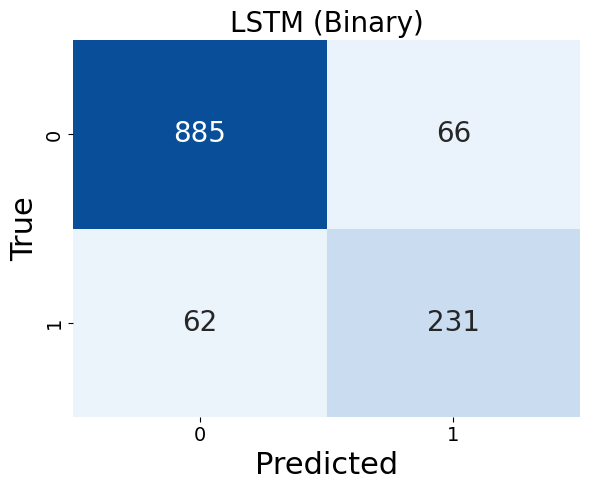

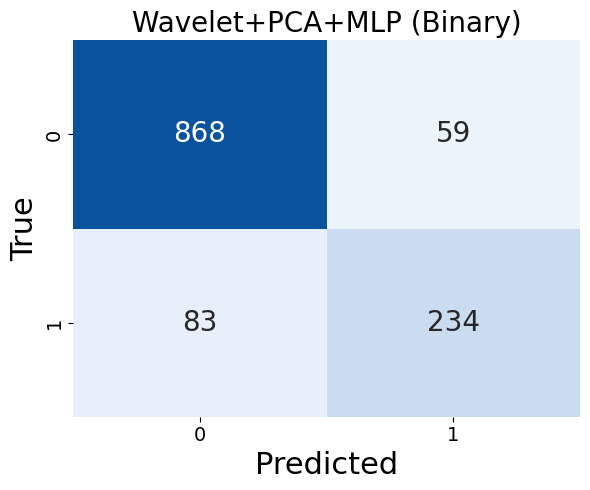

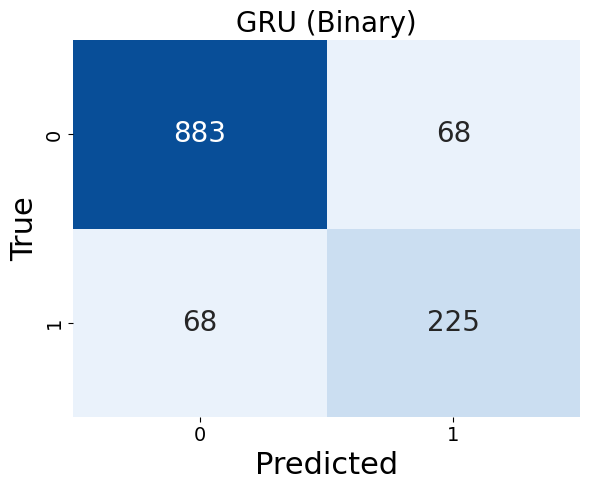

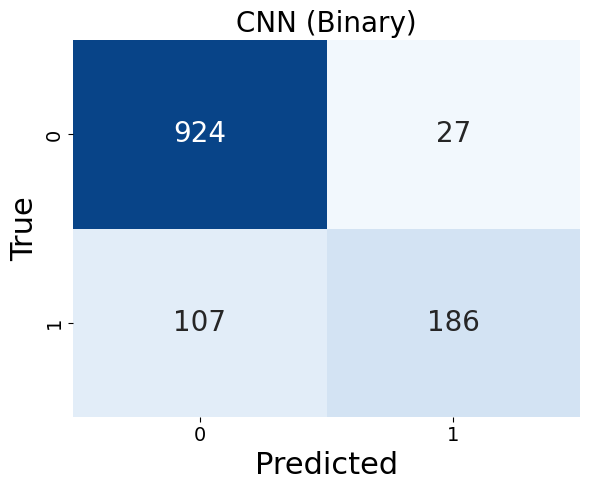

In [ ]:
import matplotlib.colors as colors

# 模型名称与配色参数
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']
vmin = 0
vmax = 1000

# 收集所有混淆矩阵
all_cms = []
for data_2, model_name in zip([transformer_df_bin, lstm_df_bin, wavelet_df_bin, gru_df_bin, cnn_df_bin], model_names):
    y_true_2 = np.array(data_2['all-labels'].iloc[0])
    y_pred_2 = np.array(data_2['all-preds'].iloc[0])

    if model_name == 'CNN':
        y_true_2 = np.where(y_true_2 == 0, 1, np.where(y_true_2 == 1, 0, y_true_2))
        y_pred_2 = np.where(y_pred_2 == 0, 1, np.where(y_pred_2 == 1, 0, y_pred_2))

    cm = confusion_matrix(y_true_2, y_pred_2)
    all_cms.append(cm)

# 绘制每个模型的混淆矩阵
for i, (cm, model_name) in enumerate(zip(all_cms, model_names)):
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=vmin, vmax=vmax, annot_kws={"size": 20}, cbar=False)
    plt.xlabel('Predicted', fontsize=22)
    plt.ylabel('True', fontsize=22)
    plt.title(f'{model_name} (Binary)', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


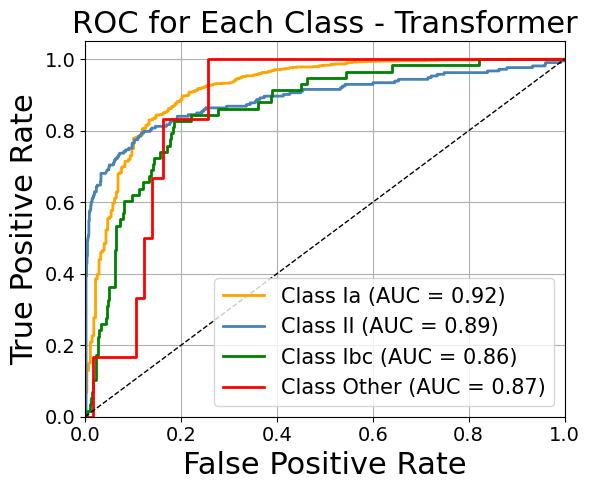

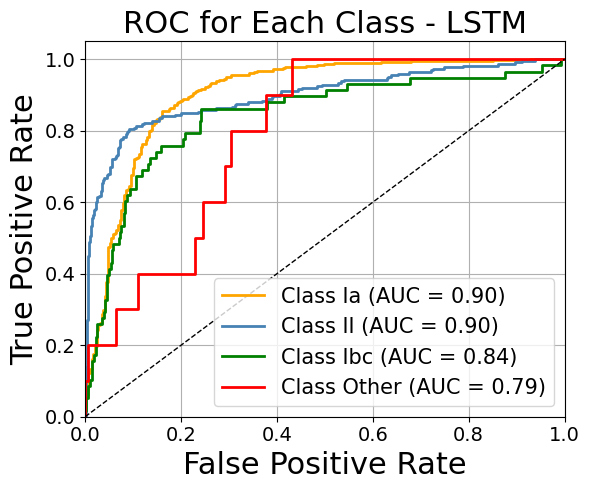

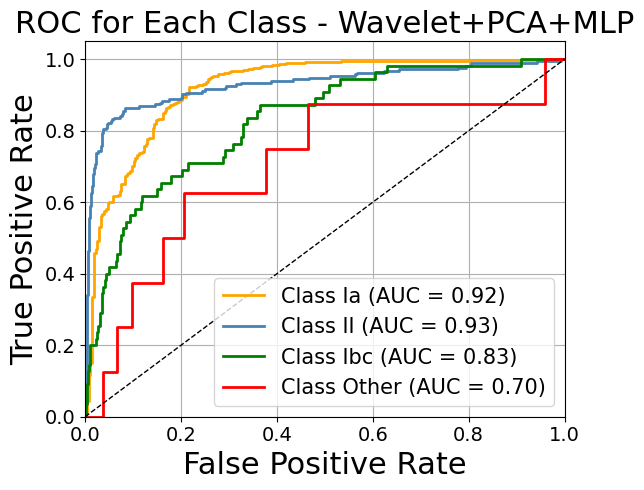

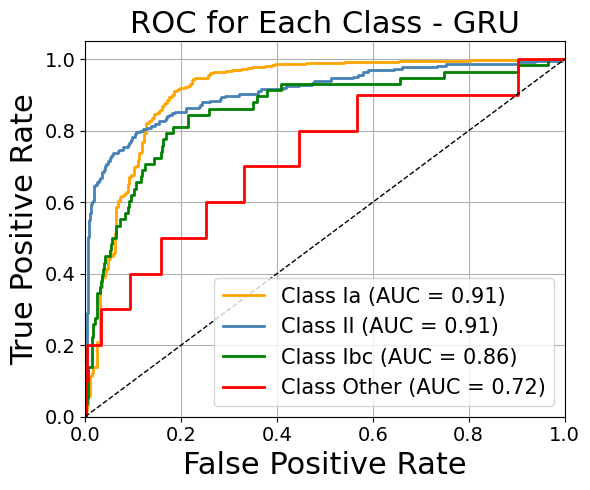

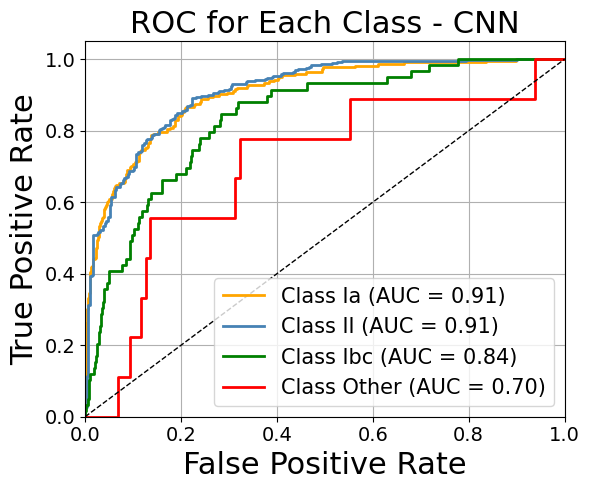

In [ ]:
# ROC曲线（四分）

colors = ['orange', 'steelblue', 'green', 'red']
class_names = ['Ia', 'II', 'Ibc', 'Other']  # index: 0=Ia, 1=II, 2=Ibc, 3=Other
# 遍历每个模型绘图
for data_4, model_name in zip([transformer_df, lstm_df, wavelet_df, gru_df, cnn_df], model_names):
    y_true = np.array(data_4['all-labels'].iloc[0])
    y_score = np.array(data_4['all-probs'].iloc[0])

    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
    n_classes = y_true_bin.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i],
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=22)
    plt.ylabel('True Positive Rate', fontsize=22)
    plt.title(f'ROC for Each Class - {model_name}', fontsize=22)
    plt.legend(loc='lower right', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


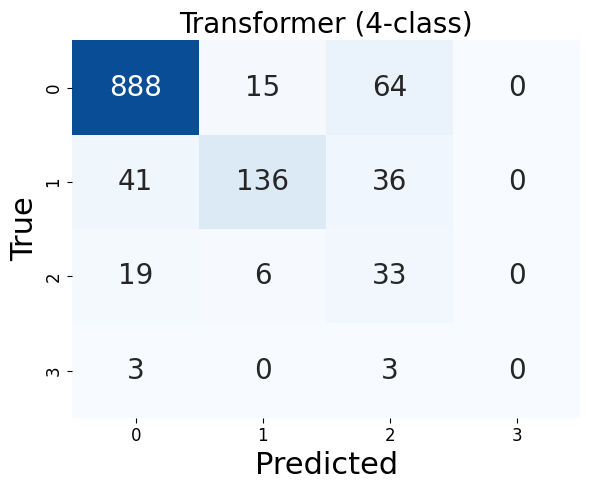

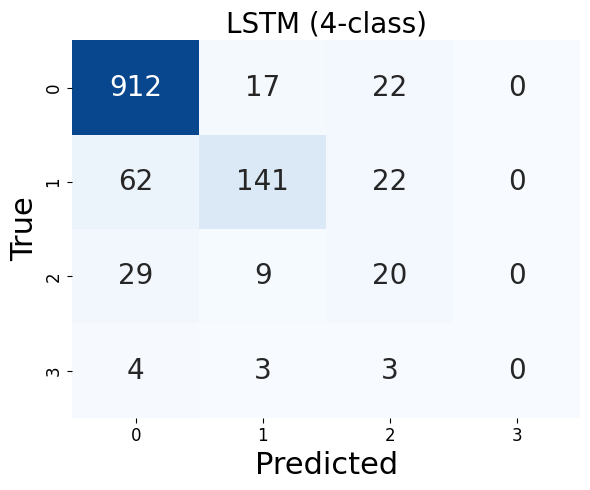

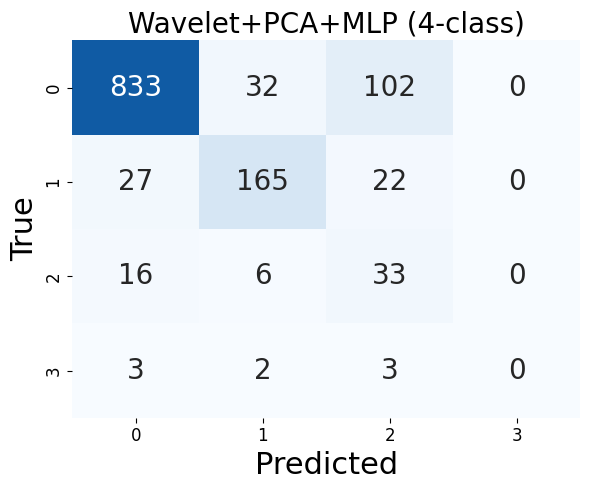

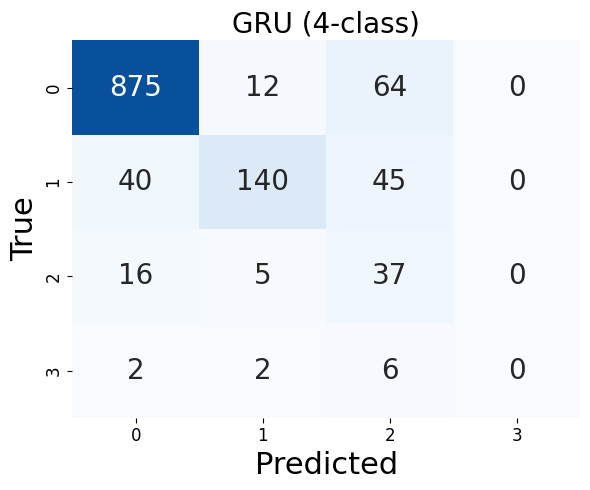

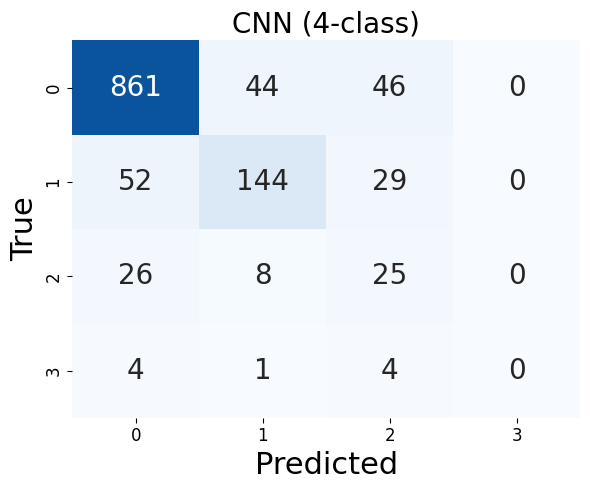

In [ ]:
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']
vmin = 0
vmax = 1000

all_cms = []

# 收集所有混淆矩阵
for data_cm_4, model_name in zip([transformer_df, lstm_df, wavelet_df, gru_df, cnn_df], model_names):
    y_true = np.array(data_cm_4['all-labels'].iloc[0])
    y_pred = np.array(data_cm_4['all-preds'].iloc[0])

    # CNN 标签翻转逻辑
    if model_name == 'CNN':
        y_true = np.where(y_true == 0, 1, np.where(y_true == 1, 0, y_true))
        y_pred = np.where(y_pred == 0, 1, np.where(y_pred == 1, 0, y_pred))

    cmatrix = confusion_matrix(y_true, y_pred)
    all_cms.append((cmatrix, model_name))

# 混淆矩阵
for cmatrix, model_name in all_cms:
    plt.figure(figsize=(6, 5))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', vmin=vmin, vmax=vmax, annot_kws={"size": 20}, cbar=False)
    plt.xlabel('Predicted', fontsize=22)
    plt.ylabel('True', fontsize=22)
    plt.title(f'{model_name} (4-class)', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()



In [ ]:
model_names = ['Transformer', 'LSTM', 'Wavelet+PCA+MLP', 'GRU', 'CNN']
four_class_data = [transformer_df, lstm_df, wavelet_df, gru_df, cnn_df]

for model_name, data in zip(model_names, four_class_data):
    y_true = np.array(data['all-labels'].iloc[0])
    y_pred = np.array(data['all-preds'].iloc[0])

    if model_name == 'CNN':
        y_true = np.where(y_true == 0, 1, np.where(y_true == 1, 0, y_true))
        y_pred = np.where(y_pred == 0, 1, np.where(y_pred == 1, 0, y_pred))

    f1 = f1_score(y_true, y_pred, average='macro') # Calculate macro-averaged F1 score
    print(f"Macro-averaged F1 score for {model_name}: {f1}")


Macro-averaged F1 score for Transformer: 0.500326466776162
Macro-averaged F1 score for LSTM: 0.491371717459045
Macro-averaged F1 score for Wavelet+PCA+MLP: 0.49926452932889737
Macro-averaged F1 score for GRU: 0.5026055884137094
Macro-averaged F1 score for CNN: 0.47459995681324485


In [ ]:
label_counts = combined_df['label'].value_counts()
total_count = len(combined_df)
label_proportions = label_counts / total_count

label_proportions


,count
label,
Ia,0.764469
II,0.181029
Ibc,0.046785
Other,0.007717
